In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('Boats_cleaned_dataset.csv')

##### Start by removing unwanted columns to just focus on boat features, may include selling information later

In [3]:
df = df.drop(['created_year', 'created_date', 'created_month', 'sellerId', 'Unnamed: 0', 'id'], axis=1)

##### Check min and max

In [4]:
print(df.price.min(), df.price.max())
df.price >= 9999999999.0
df.index[df.price >= 9999999].tolist()

500.0 9999999999.0


[10619, 16978, 18778]

##### Clean and recheck min and max

In [5]:
df_cleaned = df.drop(df.index[df.price >= 9999999].tolist(), axis=0)
print(df_cleaned.price.min(), df_cleaned.price.max())

500.0 8499000.0


##### remove unwanted columns

In [6]:
df_cleaned = df_cleaned.drop(['maxEngineYear', 'minEngineYear'], axis=1)

##### remove 0s and NaNs

In [7]:
df_cleaned = df_cleaned.replace(0,np.nan).dropna(axis = 0, how = 'any')

##### Check size

In [8]:
print(df_cleaned.shape)

(2315, 18)


##### Bin the prices logarithmically

In [9]:
df_cleaned['price_rounded'] = df_cleaned.price.apply(lambda x: 10 ** math.ceil(math.log10(x)))
df_cleaned = df_cleaned.drop(['price'], axis=1)

##### Set the features and targets

In [10]:
X = df_cleaned.drop(['price_rounded'], axis=1)
y = df_cleaned.price_rounded

X_number = X.select_dtypes(include='number')
X_number = (X_number - X_number.mean()) / X_number.std()
X_categorical = X.select_dtypes(exclude='number')
X_categorical = pd.get_dummies(X_categorical, drop_first=False)
X_categorical.head()
X = pd.concat([X_number, X_categorical], axis=1)

##### Train Regressor

In [11]:
grid = {'max_depth':np.arange(1,25)}
tree = DecisionTreeClassifier()
treeCV = GridSearchCV(tree,param_grid=grid,return_train_score=True)

treeCV.fit(X,y)
print()
print('best tree depth =',treeCV.best_params_, '  valid error rate =', (1 - treeCV.best_score_).round(3))

C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



best tree depth = {'max_depth': 24}   valid error rate = 0.061


##### Show Regressor

<Axes: xlabel='depth'>

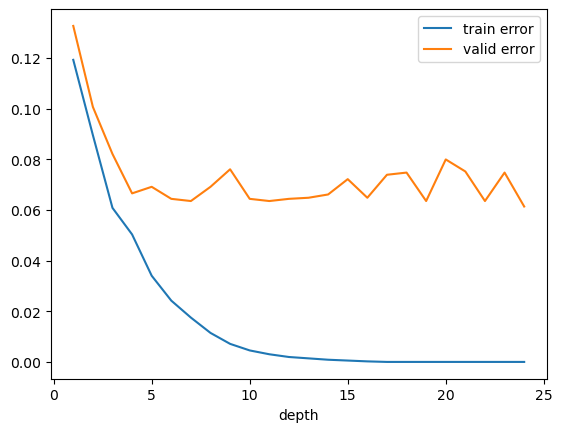

In [12]:
results = pd.DataFrame()
results['depth'] = grid['max_depth']
results['train error'] =1 - treeCV.cv_results_['mean_train_score']
results['valid error']  = 1 - treeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth',y='train error')
results.plot.line(x='depth',y='valid error',ax=ax1)

In [13]:
tree = DecisionTreeClassifier(max_depth=4) #default is to use sqrt
tree.fit(X,y)

DecisionTreeClassifier(max_depth=4)

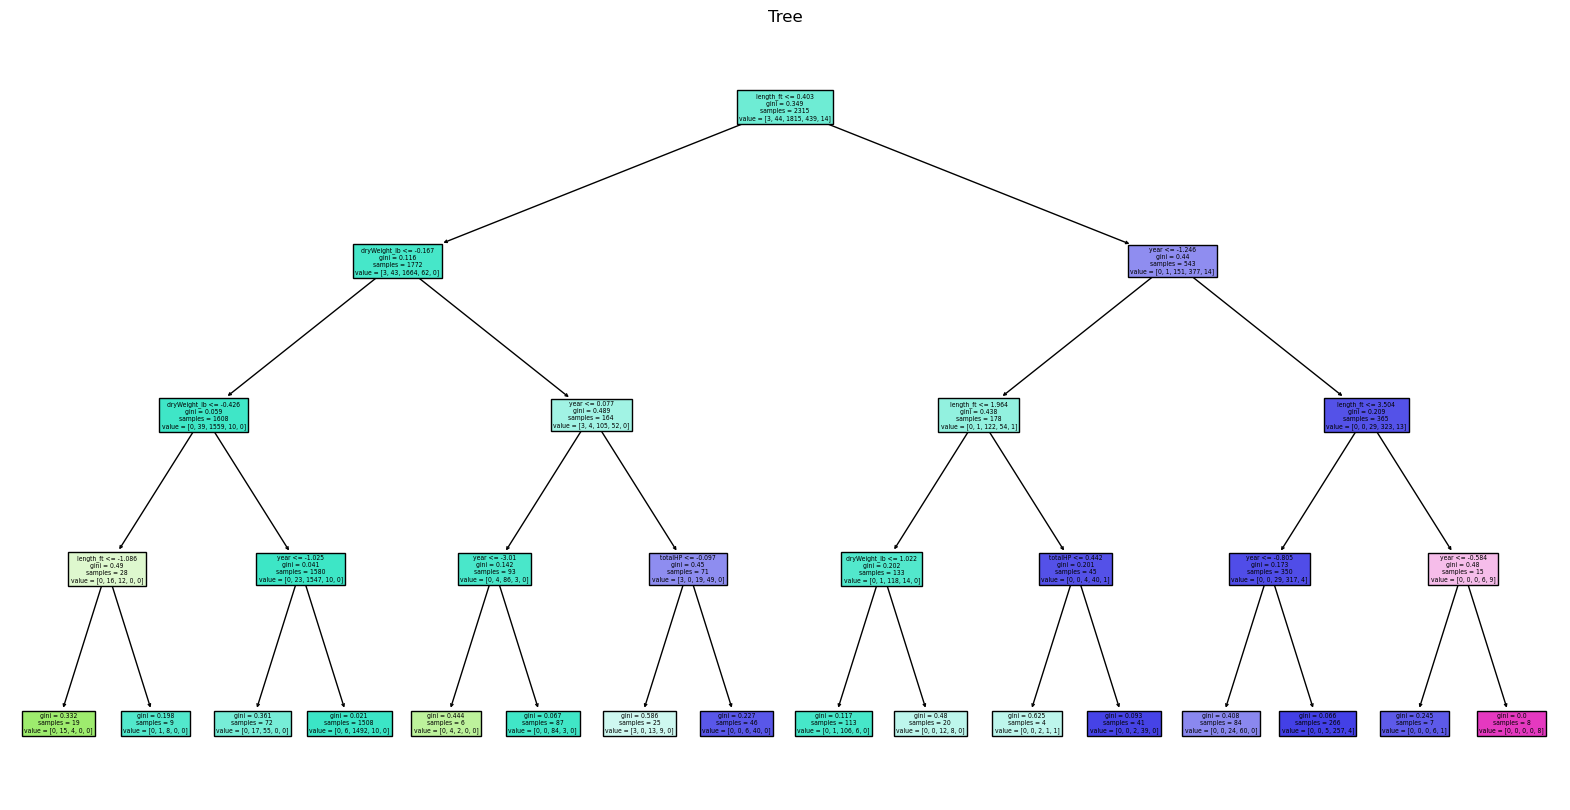

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=X.columns)
plt.title(f"Tree")
plt.show()

In [22]:
# %load "DecisionBoundary.py"
def DecisionBoundary(clf,feature_names,target_name,df):
    
    from sklearn.preprocessing import StandardScaler,LabelEncoder
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.colors import LogNorm, Normalize
    
    N     = 250   # N x N number of points for 2D grid generation
    alpha = 0.2   # point transparency
    pt_size = 200
    sns.set_palette('bright')
    cmap = sns.color_palette('bright')

    # create 2D grid of points in feature space
    X1 = df[feature_names[0]]
    X2 = df[feature_names[1]]
    XX1,XX2 = np.meshgrid(
    np.linspace(X1.min(),X1.max(),N),
    np.linspace(X2.min(),X2.max(),N))
    
    # integer code categories
    df['target_code'] = LabelEncoder().fit_transform(df[target_name])
    
    # shuffle and stratified-split data
    (df_train,df_test) = train_test_split(df,
                                          train_size=0.8,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=df[target_name],
                                          random_state=0)
    
    # assign features and targets
    features_train = df_train[feature_names]
    features_test  = df_test[feature_names]
    target_train   = df_train['target_code']
    target_test    = df_test['target_code']
    
    # standardize
    stnd = StandardScaler()
    stnd.fit(features_train)
    features_train = stnd.transform(features_train)
    features_test  = stnd.transform(features_test)
    
    # fit classifier
    clf.fit(features_train,target_train)
    
    # predict targets on 2D grid
    features_grid = np.stack([XX1.ravel(),XX2.ravel()],axis=1)
    features_grid = stnd.transform(features_grid)
    Y = clf.predict(features_grid)
    YY = Y.reshape(XX1.shape)
    
    
    # plot train set
    fig1,ax1 = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=feature_names[0],
                    y=feature_names[1],
                    hue=target_name,
                    data=df_train,
                    s=pt_size,
                    ax=ax1,
                    hue_norm=LogNorm(),
                   palette=sns.color_palette("rocket_r", as_cmap=True))
    plt.contourf(XX1,XX2,YY,alpha=alpha,colors=cmap)
    plt.title('train set')
    
    # plot test set
    fig2,ax2 = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=feature_names[0],
                          y=feature_names[1],
                          hue=target_name,
                          data=df_test,
                          s=pt_size,
                          ax=ax2,
                          hue_norm=LogNorm(),
                           palette=sns.color_palette("rocket_r", as_cmap=True))
    plt.contourf(XX1,XX2,YY,alpha=alpha,colors=cmap)
    plt.title('test set')
    
    acc_train = clf.score(features_train,target_train)
    acc_test  = clf.score(features_test,target_test)
    
    return acc_train,acc_test

C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(0.9168466522678186, 0.9028077753779697)

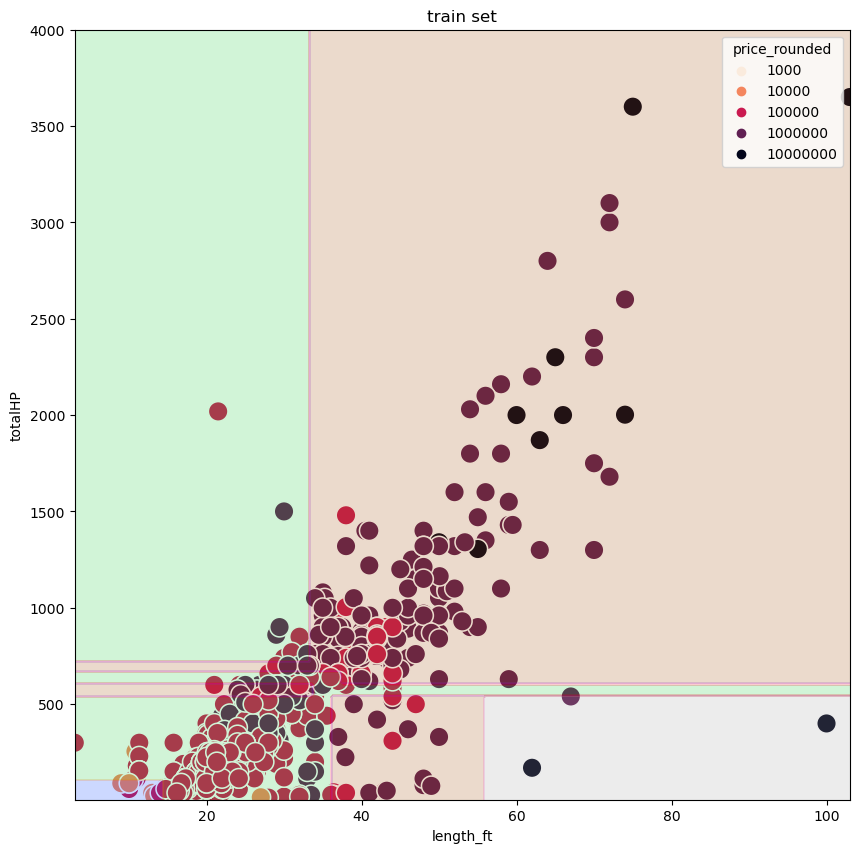

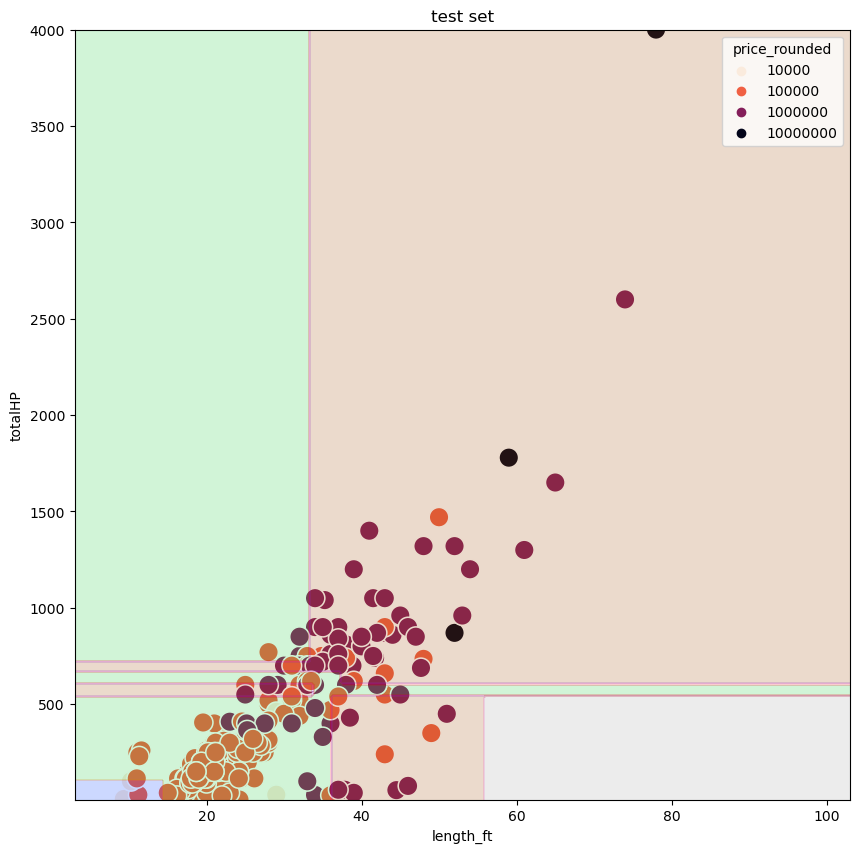

In [23]:
clf = DecisionTreeClassifier(max_depth=4)
DecisionBoundary(clf,['length_ft','totalHP'],'price_rounded',df_cleaned)